In [1]:
# First we need to import some packages
import keras
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import json
from copy import deepcopy
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras.wrappers.scikit_learn import KerasClassifier
from keras.metrics import categorical_accuracy

# Now read in the data
data=pd.read_csv('./tmdb_5000_movies.csv')

# Change data and get only what we want
data=deepcopy(data[['title','genres','overview']])

# Print out the first record
print("Data before cleaning: ")
print("Title:", data['title'][0])
print("Genres:", data['genres'][0])
print("Overview:", data['overview'][0], "\n\n")

# define a function to clean our genres from [{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]
# to [Action, Aventure, Fantasy, Science Fiction]
def clean_genres(genre_data):
    # List to hold results
    genre_list = []
    for item in genre_data:
        # Since data is json we can use the json lib
        json_data = json.loads(item)
        temp_list = []

        for dict_item in json_data:
            # Grab only the genre names
            temp_list.append(dict_item["name"])
    
        genre_list.append(temp_list)

    return genre_list

def clean_overview(overview_list):
    # List of words to remove
    words_to_remove = ["a", "and", "the", "but", "nor", "else", "or", "its", "it's", "of", "to", "in", "on", "is", "be",
                        "he", "his", "him" "she", "her", "an", "as", "for", "by", "are", "if", "it",
                        "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t",
                        "u", "v", "w", "x", "y", "z", "there", "their", "they're", "where", "wear", "were", "this", "that"
                      ]

    # List to hold results
    clean_overview_list = []
    for item in overview_list:
        # force item to be treated as a string
        item =str(item)
        
        # Split into a list of words
        words_list = item.split()
        
        temp_list = []
        # Remove any punctuation
        for word in words_list:
            # force item to be treated as a string, but first check if it is not empty
            if word:
                word = str(word)
                word = word.replace(",", "")
                word = word.replace(".", "")
                word = word.replace("\"", "")
                word = word.replace("-", "")
                word = word.replace(")", "")
                word = word.replace("(", "")
                word = word.replace("?", "")
                word = word.replace("!", "")
                word = word.replace("~", "")
                word = word.replace("`", "")
                word = word.replace("'", "")
                word = word.replace("’", "")
                word = word.replace(";", "")
                word = word.replace(":", "")
                word = word.replace("…", "")
                word = word.replace("−", "")
                temp_list.append(word)
        
        words_list = temp_list

        # Create a new list of filtered words
        filtered_words_list = [word for word in words_list if word.lower() not in words_to_remove]
        
        clean_overview_list.append(filtered_words_list)

    return clean_overview_list

data["genres"] = clean_genres(data["genres"])
data["overview"] = clean_overview(data["overview"])

# Print out the first record again
print("Data after cleaning: ")
print("Title:", data['title'][0])
print("Genres:", data['genres'][0])
print("Overview:", data['overview'][0], "\n\n")

Data before cleaning: 
Title: Avatar
Genres: [{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]
Overview: In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. 


Data after cleaning: 
Title: Avatar
Genres: ['Action', 'Adventure', 'Fantasy', 'Science Fiction']
Overview: ['22nd', 'century', 'paraplegic', 'Marine', 'dispatched', 'moon', 'Pandora', 'unique', 'mission', 'becomes', 'torn', 'between', 'following', 'orders', 'protecting', 'alien', 'civilization'] 




In [2]:
# Next we use the Tokenizer from Keras to make our life easier. It will tokenize the text and encode (vectorize) it.
# But first let's copy our data

data_copy = deepcopy(data)

# Make one for each
overview_tokenizer = Tokenizer()
genre_tokenizer = Tokenizer()

# Feed tokenizers the data
overview_tokenizer.fit_on_texts(data_copy["overview"])
genre_tokenizer.fit_on_texts(data_copy["genres"])

# Show what the tokenizers found.
print("Overview word count:", overview_tokenizer.word_counts, "\n\n")
print("Genre word count:", genre_tokenizer.word_counts, "\n\n")
print("Overview unique word count:", len(overview_tokenizer.word_counts))
print("Genre unique word count:", len(genre_tokenizer.word_counts), "\n\n")

# Show how genre/overview are index
print("Overview index values:", overview_tokenizer.word_index, "\n\n")
print("Genre index values:", genre_tokenizer.word_index, "\n\n")

Overview word count: OrderedDict([('22nd', 4), ('century', 73), ('paraplegic', 1), ('marine', 14), ('dispatched', 9), ('moon', 16), ('pandora', 1), ('unique', 25), ('mission', 151), ('becomes', 263), ('torn', 23), ('between', 221), ('following', 51), ('orders', 20), ('protecting', 13), ('alien', 67), ('civilization', 10), ('captain', 61), ('barbossa', 1), ('long', 81), ('believed', 13), ('dead', 118), ('has', 949), ('come', 146), ('back', 313), ('life', 799), ('headed', 15), ('edge', 9), ('earth', 137), ('with', 2533), ('will', 416), ('turner', 10), ('elizabeth', 25), ('swann', 1), ('nothing', 71), ('quite', 18), ('seems', 91), ('cryptic', 4), ('message', 10), ('from', 1325), ('bonds', 10), ('past', 151), ('sends', 34), ('him', 815), ('trail', 28), ('uncover', 45), ('sinister', 30), ('organization', 34), ('while', 323), ('battles', 15), ('political', 47), ('forces', 124), ('keep', 104), ('secret', 175), ('service', 39), ('alive', 55), ('bond', 72), ('peels', 1), ('layers', 2), ('deceit

In [3]:
# Now we encode the genres and overview to create a matrix
encoded_overview = overview_tokenizer.texts_to_matrix(data_copy["overview"], mode="count")
encoded_genre = genre_tokenizer.texts_to_matrix(data_copy["genres"], mode="count")

print("Encoded overview data set:", encoded_overview, "\n\n")
print("Encoded genre data set:", encoded_genre, "\n\n")
print("Encoded overview data width:", len(encoded_overview[0]))
print("Encoded overview data height:", len(encoded_overview))
print("Encoded genre data width:", len(encoded_genre[0]))
print("Encoded genre data height:", len(encoded_genre), "\n\n")


Encoded overview data set: [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]] 


Encoded genre data set: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 


Encoded overview data width: 23662
Encoded overview data height: 4803
Encoded genre data width: 21
Encoded genre data height: 4803 




In [4]:
# Our data is now ready :)... I think.
print("Sample Data:", data_copy["title"][0], data_copy["genres"][0], data_copy["overview"][0])
print("Sample Data Encoded:", data_copy["title"][0], encoded_genre[0], encoded_overview[0], "\n\n")

Sample Data: Avatar ['Action', 'Adventure', 'Fantasy', 'Science Fiction'] ['22nd', 'century', 'paraplegic', 'Marine', 'dispatched', 'moon', 'Pandora', 'unique', 'mission', 'becomes', 'torn', 'between', 'following', 'orders', 'protecting', 'alien', 'civilization']
Sample Data Encoded: Avatar [0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.] 




In [5]:
# Now we assign stuff back to our data pandaframe and delete data_copy

# Here we append to and assign to our data pandaframe
data["genres"] = data_copy["genres"]
data["overview"] = data_copy["overview"]
data["title"] = data_copy["title"]
data["one_hot_genre"] = list(encoded_genre)
data["one_hot_overview"] = list(encoded_overview)
data = data.append({"genre_word_index": genre_tokenizer.word_index}, ignore_index=True)
data = data.append({"overview_word_index": overview_tokenizer.word_index}, ignore_index=True)
del data_copy

# Lastly Print our updated data pandaframe
print(data)

                                         title  \
0                                       Avatar   
1     Pirates of the Caribbean: At World's End   
2                                      Spectre   
3                        The Dark Knight Rises   
4                                  John Carter   
...                                        ...   
4800                 Signed, Sealed, Delivered   
4801                          Shanghai Calling   
4802                         My Date with Drew   
4803                                       NaN   
4804                                       NaN   

                                             genres  \
0     [Action, Adventure, Fantasy, Science Fiction]   
1                      [Adventure, Fantasy, Action]   
2                        [Action, Adventure, Crime]   
3                  [Action, Crime, Drama, Thriller]   
4              [Action, Adventure, Science Fiction]   
...                                             ...   
4800          

In [6]:
# Cool, now we can begin to build our nerual network, but first we need x_train, x_test, y_train, y_test
(X_train, X_test, y_train, y_test) = train_test_split(encoded_overview, encoded_genre, test_size=0.20)
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape, "X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

# Make the NN (Modified version from HW2)
def create_NN(hidden_layers = [1000], act = 'relu', opt = 'rmsprop', in_dim=X_train.shape[1], out_dim=y_train.shape[1]): 
    '''create a deep feedforwad neural network using keras
    
    Parameters
    -----------
    hidden_layers: a list that defines the numbers of hidden nodes for all hidden layers, e.g., [1000] indicates
    the nn has only one hidden layer with 1000 nodes, while [1000, 500] defines two hidden layers and the first
    layer has 1000 nodes and the second has 500 nodes.
    act: activation function for all hidden layers
    opt: optimizer
    
    Returns
    -------
    myNN: the neural network model
    
    ''' 
    myNN = keras.models.Sequential()
    
    
    num_hidden_layers = 0
    for layer in hidden_layers:
        num_hidden_layers = num_hidden_layers + 1 
        print("Hidden Layer:", num_hidden_layers, "Size of:", layer)
        #2.1 build all hidden layers
        myNN.add(keras.layers.Dense(
        units=layer,
        input_dim=in_dim,
        activation=act))

    # build the output layer and use sigmoid, https://stackoverflow.com/questions/44164749/how-does-keras-handle-multilabel-classification
    myNN.add(keras.layers.Dense(
    units=out_dim,
    activation='sigmoid'))

    #2.3 choose the optimizer, compile the network and return it. Use 'accuracy' as the metrics
    myNN.compile(optimizer=opt, loss='binary_crossentropy', metrics=[categorical_accuracy])
    return myNN
    
h_nodes = [1000, 500] # two hidden layers with 1000 and 500 nodes, respectively.
myNN = create_NN(hidden_layers=h_nodes, act='relu', opt='adam', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
myNN.summary()

# Note to self and others. This took about ~30 for my machine to complete
history1 = myNN.fit(X_train, y_train, epochs=5, batch_size=2000, verbose=2)
history2 = myNN.fit(X_train, y_train, epochs=50, batch_size=2000, verbose=2)
history3 = myNN.fit(X_train, y_train, epochs=500, batch_size=2000, verbose=2)

X_train shape: (3842, 23662) y_train shape: (3842, 21) X_test shape: (961, 23662) y_test shape: (961, 21)
Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              23663000  
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_2 (Dense)              (None, 21)                10521     
Total params: 24,174,021
Trainable params: 24,174,021
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
2/2 - 3s - loss: 0.6726 - categorical_accuracy: 0.2228
Epoch 2/5
2/2 - 3s - loss: 0.5580 - categorical_accuracy: 0.4849
Epoch 3/5
2/2 - 2s - loss: 0.4142 - categorical_accuracy: 0.4831
Epoch 4/5
2/2 

Epoch 52/500
2/2 - 4s - loss: 3.4471e-04 - categorical_accuracy: 0.7140
Epoch 53/500
2/2 - 3s - loss: 3.3758e-04 - categorical_accuracy: 0.7137
Epoch 54/500
2/2 - 4s - loss: 3.3097e-04 - categorical_accuracy: 0.7140
Epoch 55/500
2/2 - 4s - loss: 3.2446e-04 - categorical_accuracy: 0.7132
Epoch 56/500
2/2 - 3s - loss: 3.1815e-04 - categorical_accuracy: 0.7126
Epoch 57/500
2/2 - 5s - loss: 3.1200e-04 - categorical_accuracy: 0.7121
Epoch 58/500
2/2 - 4s - loss: 3.0609e-04 - categorical_accuracy: 0.7119
Epoch 59/500
2/2 - 3s - loss: 3.0026e-04 - categorical_accuracy: 0.7119
Epoch 60/500
2/2 - 3s - loss: 2.9453e-04 - categorical_accuracy: 0.7108
Epoch 61/500
2/2 - 3s - loss: 2.8884e-04 - categorical_accuracy: 0.7098
Epoch 62/500
2/2 - 3s - loss: 2.8352e-04 - categorical_accuracy: 0.7087
Epoch 63/500
2/2 - 4s - loss: 2.7815e-04 - categorical_accuracy: 0.7080
Epoch 64/500
2/2 - 4s - loss: 2.7305e-04 - categorical_accuracy: 0.7074
Epoch 65/500
2/2 - 3s - loss: 2.6812e-04 - categorical_accuracy:

Epoch 165/500
2/2 - 3s - loss: 7.1039e-05 - categorical_accuracy: 0.7098
Epoch 166/500
2/2 - 3s - loss: 7.0366e-05 - categorical_accuracy: 0.7103
Epoch 167/500
2/2 - 3s - loss: 6.9693e-05 - categorical_accuracy: 0.7100
Epoch 168/500
2/2 - 3s - loss: 6.9040e-05 - categorical_accuracy: 0.7093
Epoch 169/500
2/2 - 3s - loss: 6.8390e-05 - categorical_accuracy: 0.7087
Epoch 170/500
2/2 - 3s - loss: 6.7753e-05 - categorical_accuracy: 0.7087
Epoch 171/500
2/2 - 3s - loss: 6.7124e-05 - categorical_accuracy: 0.7085
Epoch 172/500
2/2 - 3s - loss: 6.6514e-05 - categorical_accuracy: 0.7085
Epoch 173/500
2/2 - 3s - loss: 6.5886e-05 - categorical_accuracy: 0.7085
Epoch 174/500
2/2 - 3s - loss: 6.5283e-05 - categorical_accuracy: 0.7087
Epoch 175/500
2/2 - 3s - loss: 6.4691e-05 - categorical_accuracy: 0.7087
Epoch 176/500
2/2 - 3s - loss: 6.4106e-05 - categorical_accuracy: 0.7085
Epoch 177/500
2/2 - 4s - loss: 6.3530e-05 - categorical_accuracy: 0.7085
Epoch 178/500
2/2 - 4s - loss: 6.2961e-05 - categor

Epoch 278/500
2/2 - 3s - loss: 3.0195e-05 - categorical_accuracy: 0.7072
Epoch 279/500
2/2 - 3s - loss: 3.0011e-05 - categorical_accuracy: 0.7072
Epoch 280/500
2/2 - 4s - loss: 2.9831e-05 - categorical_accuracy: 0.7069
Epoch 281/500
2/2 - 3s - loss: 2.9650e-05 - categorical_accuracy: 0.7069
Epoch 282/500
2/2 - 3s - loss: 2.9473e-05 - categorical_accuracy: 0.7067
Epoch 283/500
2/2 - 5s - loss: 2.9295e-05 - categorical_accuracy: 0.7059
Epoch 284/500
2/2 - 3s - loss: 2.9123e-05 - categorical_accuracy: 0.7059
Epoch 285/500
2/2 - 3s - loss: 2.8948e-05 - categorical_accuracy: 0.7056
Epoch 286/500
2/2 - 3s - loss: 2.8776e-05 - categorical_accuracy: 0.7061
Epoch 287/500
2/2 - 3s - loss: 2.8608e-05 - categorical_accuracy: 0.7059
Epoch 288/500
2/2 - 3s - loss: 2.8437e-05 - categorical_accuracy: 0.7061
Epoch 289/500
2/2 - 3s - loss: 2.8269e-05 - categorical_accuracy: 0.7059
Epoch 290/500
2/2 - 3s - loss: 2.8105e-05 - categorical_accuracy: 0.7059
Epoch 291/500
2/2 - 3s - loss: 2.7941e-05 - categor

Epoch 391/500
2/2 - 3s - loss: 1.6742e-05 - categorical_accuracy: 0.7025
Epoch 392/500
2/2 - 3s - loss: 1.6666e-05 - categorical_accuracy: 0.7028
Epoch 393/500
2/2 - 3s - loss: 1.6593e-05 - categorical_accuracy: 0.7022
Epoch 394/500
2/2 - 3s - loss: 1.6517e-05 - categorical_accuracy: 0.7022
Epoch 395/500
2/2 - 3s - loss: 1.6445e-05 - categorical_accuracy: 0.7025
Epoch 396/500
2/2 - 3s - loss: 1.6371e-05 - categorical_accuracy: 0.7025
Epoch 397/500
2/2 - 3s - loss: 1.6298e-05 - categorical_accuracy: 0.7025
Epoch 398/500
2/2 - 3s - loss: 1.6225e-05 - categorical_accuracy: 0.7022
Epoch 399/500
2/2 - 3s - loss: 1.6154e-05 - categorical_accuracy: 0.7022
Epoch 400/500
2/2 - 3s - loss: 1.6082e-05 - categorical_accuracy: 0.7022
Epoch 401/500
2/2 - 3s - loss: 1.6012e-05 - categorical_accuracy: 0.7022
Epoch 402/500
2/2 - 3s - loss: 1.5941e-05 - categorical_accuracy: 0.7022
Epoch 403/500
2/2 - 3s - loss: 1.5871e-05 - categorical_accuracy: 0.7022
Epoch 404/500
2/2 - 3s - loss: 1.5802e-05 - categor

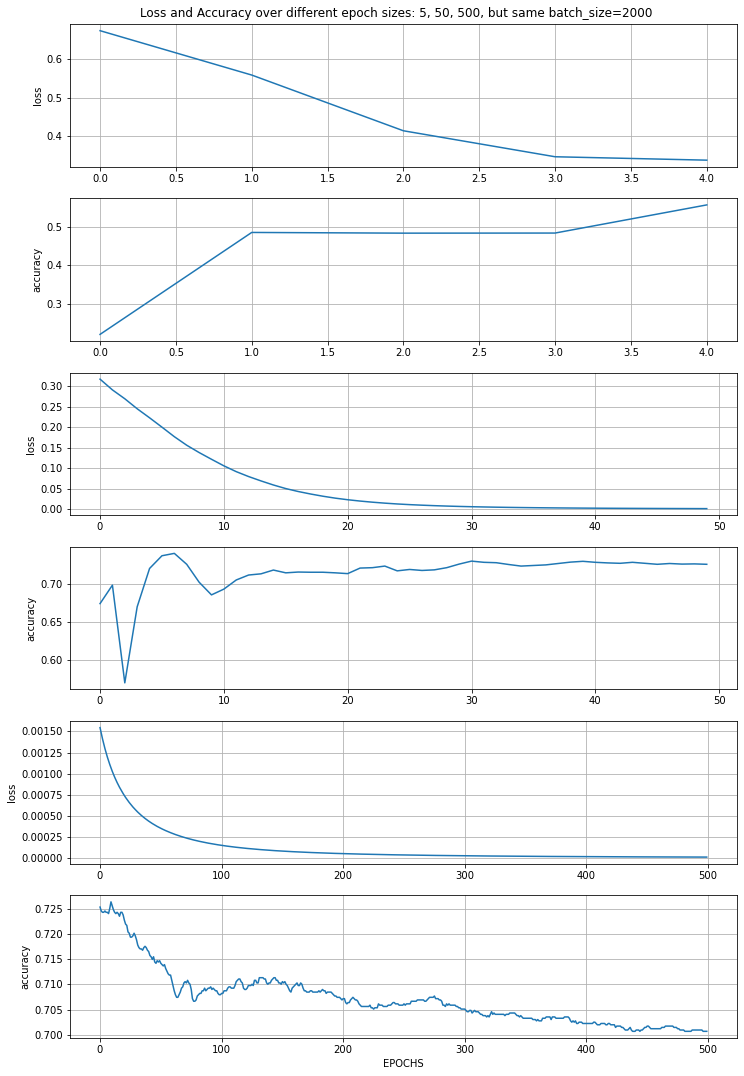

In [8]:
# Lets Plot the history, keys: "loss", "accuracy"
fig1, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6,1)
fig1.suptitle("Loss and Accuracy over different epoch sizes: 5, 50, 500, but same batch_size=2000")
fig1.set_size_inches(10, 15, forward=True)
fig1.tight_layout()

ax1.set_ylabel("loss")
ax1.plot(history1.epoch, history1.history["loss"])
ax1.grid()

ax2.set_ylabel("accuracy")
ax2.plot(history1.epoch, history1.history["categorical_accuracy"])
ax2.grid()

ax3.set_ylabel("loss")
ax3.plot(history2.epoch, history2.history["loss"])
ax3.grid()

ax4.set_ylabel("accuracy")
ax4.plot(history2.epoch, history2.history["categorical_accuracy"])
ax4.grid()

ax5.set_ylabel("loss")
ax5.plot(history3.epoch, history3.history["loss"])
ax5.grid()

ax6.set_xlabel("EPOCHS")
ax6.set_ylabel("accuracy")
ax6.plot(history3.epoch, history3.history["categorical_accuracy"])
ax6.grid()
plt.show()

In [12]:
# Now let's try to find the best parameters for our NN (Simular to HW2)

def nn_params_search(nn, X, y, param_grid): # 30 points
    '''Search best paramaters
    
    Parameters
    ----------
    X_train: features
    y_train: target of the input
    param_grid: a dict that defines the parameters
    
    Returns
    -------
    best_params_
        
    '''
    ## add your code here. set cv = 3, scoring = 'accuracy', and verbose = 2
    grid = GridSearchCV(estimator=nn, cv = 3, scoring = 'accuracy', verbose = 2, param_grid=param_grid)
    results = grid.fit(X, y)
    return results.best_params_
    
    ##

# wrap keras model to use in sklearn
nn = KerasClassifier(build_fn = create_NN, batch_size = 64, epochs = 10) # using the keras wapper
param_grid = {'batch_size': [1000, 2000], 
              'act':['relu', 'sigmoid'], 'opt': ['sgd', 'adam']}

best_params = nn_params_search(nn, X_train, y_train, param_grid = param_grid)
print('\nBest parameters: ', best_params)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Hidden Layer: 1 Size of: 1000
Epoch 1/10
3/3 [==============================] - 3s 584ms/step - loss: 0.6896 - categorical_accuracy: 0.0381
Epoch 2/10
3/3 [==============================] - 2s 610ms/step - loss: 0.6889 - categorical_accuracy: 0.0392
Epoch 3/10
3/3 [==============================] - 2s 702ms/step - loss: 0.6882 - categorical_accuracy: 0.0421
Epoch 4/10
3/3 [==============================] - 2s 639ms/step - loss: 0.6876 - categorical_accuracy: 0.0437
Epoch 5/10
3/3 [==============================] - 2s 592ms/step - loss: 0.6870 - categorical_accuracy: 0.0425
Epoch 6/10
3/3 [==============================] - 2s 643ms/step - loss: 0.6864 - categorical_accuracy: 0.0445
Epoch 7/10
3/3 [==============================] - 2s 588ms/step - loss: 0.6858 - categorical_accuracy: 0.0487
Epoch 8/10
3/3 [==============================] - 2s 583ms/step - loss: 0.6851 - categorical_accuracy: 0.0550
Epoch 9/10
3/3 [==============

C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-pack

[CV] END .................act=relu, batch_size=1000, opt=sgd; total time=  21.8s
Hidden Layer: 1 Size of: 1000
Epoch 1/10
3/3 [==============================] - 2s 580ms/step - loss: 0.6946 - categorical_accuracy: 0.2279
Epoch 2/10
3/3 [==============================] - 2s 575ms/step - loss: 0.6941 - categorical_accuracy: 0.2344
Epoch 3/10
3/3 [==============================] - 2s 575ms/step - loss: 0.6934 - categorical_accuracy: 0.2331
Epoch 4/10
3/3 [==============================] - 2s 591ms/step - loss: 0.6927 - categorical_accuracy: 0.2417
Epoch 5/10
3/3 [==============================] - 2s 612ms/step - loss: 0.6922 - categorical_accuracy: 0.2466
Epoch 6/10
3/3 [==============================] - 3s 1s/step - loss: 0.6914 - categorical_accuracy: 0.2540
Epoch 7/10
3/3 [==============================] - 3s 631ms/step - loss: 0.6908 - categorical_accuracy: 0.2571
Epoch 8/10
3/3 [==============================] - 2s 568ms/step - loss: 0.6903 - categorical_accuracy: 0.2678
Epoch 9/10
3

C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-pack

[CV] END .................act=relu, batch_size=1000, opt=sgd; total time=  22.7s
Hidden Layer: 1 Size of: 1000
Epoch 1/10
3/3 [==============================] - 2s 570ms/step - loss: 0.6930 - categorical_accuracy: 0.0298
Epoch 2/10
3/3 [==============================] - 2s 584ms/step - loss: 0.6923 - categorical_accuracy: 0.0308
Epoch 3/10
3/3 [==============================] - 2s 590ms/step - loss: 0.6917 - categorical_accuracy: 0.0296
Epoch 4/10
3/3 [==============================] - 2s 568ms/step - loss: 0.6911 - categorical_accuracy: 0.0351
Epoch 5/10
3/3 [==============================] - 2s 569ms/step - loss: 0.6904 - categorical_accuracy: 0.0353
Epoch 6/10
3/3 [==============================] - 2s 571ms/step - loss: 0.6898 - categorical_accuracy: 0.0379
Epoch 7/10
3/3 [==============================] - 2s 611ms/step - loss: 0.6892 - categorical_accuracy: 0.0373
Epoch 8/10
3/3 [==============================] - 2s 576ms/step - loss: 0.6885 - categorical_accuracy: 0.0386
Epoch 9/1

C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-pack

[CV] END .................act=relu, batch_size=1000, opt=sgd; total time=  20.5s
Hidden Layer: 1 Size of: 1000
Epoch 1/10
3/3 [==============================] - 3s 647ms/step - loss: 0.6749 - categorical_accuracy: 0.1586
Epoch 2/10
3/3 [==============================] - 2s 589ms/step - loss: 0.5301 - categorical_accuracy: 0.6031
Epoch 3/10
3/3 [==============================] - 2s 584ms/step - loss: 0.4036 - categorical_accuracy: 0.5402
Epoch 4/10
3/3 [==============================] - 2s 592ms/step - loss: 0.3324 - categorical_accuracy: 0.5345
Epoch 5/10
3/3 [==============================] - 2s 585ms/step - loss: 0.2956 - categorical_accuracy: 0.6348
Epoch 6/10
3/3 [==============================] - 2s 581ms/step - loss: 0.2670 - categorical_accuracy: 0.7427
Epoch 7/10
3/3 [==============================] - 2s 590ms/step - loss: 0.2378 - categorical_accuracy: 0.7698
Epoch 8/10
3/3 [==============================] - 2s 609ms/step - loss: 0.2106 - categorical_accuracy: 0.7636
Epoch 9/1

C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END ................act=relu, batch_size=1000, opt=adam; total time=  21.1s


C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, 

Hidden Layer: 1 Size of: 1000
Epoch 1/10
3/3 [==============================] - 3s 609ms/step - loss: 0.6700 - categorical_accuracy: 0.1060
Epoch 2/10
3/3 [==============================] - 2s 605ms/step - loss: 0.5274 - categorical_accuracy: 0.5773
Epoch 3/10
3/3 [==============================] - 3s 1000ms/step - loss: 0.3999 - categorical_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 2s 599ms/step - loss: 0.3295 - categorical_accuracy: 0.4992
Epoch 5/10
3/3 [==============================] - 2s 607ms/step - loss: 0.2926 - categorical_accuracy: 0.6106
Epoch 6/10
3/3 [==============================] - 2s 635ms/step - loss: 0.2628 - categorical_accuracy: 0.7632
Epoch 7/10
3/3 [==============================] - 2s 597ms/step - loss: 0.2347 - categorical_accuracy: 0.7664
Epoch 8/10
3/3 [==============================] - 2s 604ms/step - loss: 0.2085 - categorical_accuracy: 0.7354
Epoch 9/10
3/3 [==============================] - 2s 593ms/step - loss: 0.1849 - categori

C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END ................act=relu, batch_size=1000, opt=adam; total time=  22.5s


C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, 

Hidden Layer: 1 Size of: 1000
Epoch 1/10
3/3 [==============================] - 3s 686ms/step - loss: 0.6723 - categorical_accuracy: 0.0766
Epoch 2/10
3/3 [==============================] - 2s 680ms/step - loss: 0.5296 - categorical_accuracy: 0.5811
Epoch 3/10
3/3 [==============================] - 2s 672ms/step - loss: 0.4033 - categorical_accuracy: 0.5122
Epoch 4/10
3/3 [==============================] - 2s 698ms/step - loss: 0.3301 - categorical_accuracy: 0.4855
Epoch 5/10
3/3 [==============================] - 2s 729ms/step - loss: 0.2919 - categorical_accuracy: 0.6102
Epoch 6/10
3/3 [==============================] - 2s 663ms/step - loss: 0.2633 - categorical_accuracy: 0.7430
Epoch 7/10
3/3 [==============================] - 2s 605ms/step - loss: 0.2388 - categorical_accuracy: 0.7307
Epoch 8/10
3/3 [==============================] - 2s 633ms/step - loss: 0.2106 - categorical_accuracy: 0.7257
Epoch 9/10
3/3 [==============================] - 2s 581ms/step - loss: 0.1842 - categoric

C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END ................act=relu, batch_size=1000, opt=adam; total time=  23.4s


C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, 

Hidden Layer: 1 Size of: 1000
Epoch 1/10
2/2 [==============================] - 2s 431ms/step - loss: 0.6905 - categorical_accuracy: 0.0646
Epoch 2/10
2/2 [==============================] - 2s 424ms/step - loss: 0.6902 - categorical_accuracy: 0.0684
Epoch 3/10
2/2 [==============================] - 2s 433ms/step - loss: 0.6897 - categorical_accuracy: 0.0705
Epoch 4/10
2/2 [==============================] - 2s 424ms/step - loss: 0.6893 - categorical_accuracy: 0.0739
Epoch 5/10
2/2 [==============================] - 2s 441ms/step - loss: 0.6888 - categorical_accuracy: 0.0759
Epoch 6/10
2/2 [==============================] - 2s 462ms/step - loss: 0.6884 - categorical_accuracy: 0.0766
Epoch 7/10
2/2 [==============================] - 2s 418ms/step - loss: 0.6880 - categorical_accuracy: 0.0769
Epoch 8/10
2/2 [==============================] - 2s 400ms/step - loss: 0.6876 - categorical_accuracy: 0.0813
Epoch 9/10
2/2 [==============================] - 2s 424ms/step - loss: 0.6872 - categoric

C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END .................act=relu, batch_size=2000, opt=sgd; total time=  19.7s


C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, 

Hidden Layer: 1 Size of: 1000
Epoch 1/10
2/2 [==============================] - 4s 511ms/step - loss: 0.6937 - categorical_accuracy: 0.0171
Epoch 2/10
2/2 [==============================] - 2s 448ms/step - loss: 0.6932 - categorical_accuracy: 0.0177
Epoch 3/10
2/2 [==============================] - 2s 419ms/step - loss: 0.6928 - categorical_accuracy: 0.0178
Epoch 4/10
2/2 [==============================] - 2s 498ms/step - loss: 0.6924 - categorical_accuracy: 0.0188
Epoch 5/10
2/2 [==============================] - 2s 460ms/step - loss: 0.6920 - categorical_accuracy: 0.0181
Epoch 6/10
2/2 [==============================] - 2s 501ms/step - loss: 0.6916 - categorical_accuracy: 0.0211
Epoch 7/10
2/2 [==============================] - 2s 436ms/step - loss: 0.6911 - categorical_accuracy: 0.0214
Epoch 8/10
2/2 [==============================] - 2s 454ms/step - loss: 0.6907 - categorical_accuracy: 0.0223
Epoch 9/10
2/2 [==============================] - 2s 477ms/step - loss: 0.6903 - categoric

C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END .................act=relu, batch_size=2000, opt=sgd; total time=  23.5s


C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, 

Hidden Layer: 1 Size of: 1000
Epoch 1/10
2/2 [==============================] - 2s 433ms/step - loss: 0.6929 - categorical_accuracy: 0.0694
Epoch 2/10
2/2 [==============================] - 2s 415ms/step - loss: 0.6925 - categorical_accuracy: 0.0692
Epoch 3/10
2/2 [==============================] - 2s 458ms/step - loss: 0.6921 - categorical_accuracy: 0.0722
Epoch 4/10
2/2 [==============================] - 2s 497ms/step - loss: 0.6917 - categorical_accuracy: 0.0732
Epoch 5/10
2/2 [==============================] - 2s 452ms/step - loss: 0.6912 - categorical_accuracy: 0.0755
Epoch 6/10
2/2 [==============================] - 2s 467ms/step - loss: 0.6908 - categorical_accuracy: 0.0763
Epoch 7/10
2/2 [==============================] - 2s 428ms/step - loss: 0.6904 - categorical_accuracy: 0.0777
Epoch 8/10
2/2 [==============================] - 2s 418ms/step - loss: 0.6900 - categorical_accuracy: 0.0784
Epoch 9/10
2/2 [==============================] - 2s 410ms/step - loss: 0.6895 - categoric

C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END .................act=relu, batch_size=2000, opt=sgd; total time=  20.7s


C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, 

Hidden Layer: 1 Size of: 1000
Epoch 1/10
2/2 [==============================] - 3s 468ms/step - loss: 0.6871 - categorical_accuracy: 0.1091
Epoch 2/10
2/2 [==============================] - 2s 474ms/step - loss: 0.5874 - categorical_accuracy: 0.6043
Epoch 3/10
2/2 [==============================] - 2s 445ms/step - loss: 0.4897 - categorical_accuracy: 0.6233
Epoch 4/10
2/2 [==============================] - 2s 458ms/step - loss: 0.4059 - categorical_accuracy: 0.5570
Epoch 5/10
2/2 [==============================] - 2s 459ms/step - loss: 0.3483 - categorical_accuracy: 0.5390
Epoch 6/10
2/2 [==============================] - 2s 475ms/step - loss: 0.3130 - categorical_accuracy: 0.6038
Epoch 7/10
2/2 [==============================] - 2s 569ms/step - loss: 0.2892 - categorical_accuracy: 0.6897
Epoch 8/10
2/2 [==============================] - 4s 623ms/step - loss: 0.2697 - categorical_accuracy: 0.7495
Epoch 9/10
2/2 [==============================] - 2s 578ms/step - loss: 0.2509 - categoric

C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END ................act=relu, batch_size=2000, opt=adam; total time=  24.6s


C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, 

Hidden Layer: 1 Size of: 1000
Epoch 1/10
2/2 [==============================] - 2s 468ms/step - loss: 0.6827 - categorical_accuracy: 0.0657
Epoch 2/10
2/2 [==============================] - 2s 478ms/step - loss: 0.5845 - categorical_accuracy: 0.5153
Epoch 3/10
2/2 [==============================] - 2s 454ms/step - loss: 0.4865 - categorical_accuracy: 0.5833
Epoch 4/10
2/2 [==============================] - 2s 519ms/step - loss: 0.4022 - categorical_accuracy: 0.5244
Epoch 5/10
2/2 [==============================] - 2s 546ms/step - loss: 0.3451 - categorical_accuracy: 0.5085
Epoch 6/10
2/2 [==============================] - 2s 467ms/step - loss: 0.3109 - categorical_accuracy: 0.5513
Epoch 7/10
2/2 [==============================] - 2s 477ms/step - loss: 0.2884 - categorical_accuracy: 0.6590
Epoch 8/10
2/2 [==============================] - 2s 651ms/step - loss: 0.2700 - categorical_accuracy: 0.7500
Epoch 9/10
2/2 [==============================] - 2s 517ms/step - loss: 0.2508 - categoric

C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END ................act=relu, batch_size=2000, opt=adam; total time=  23.0s


C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, 

Hidden Layer: 1 Size of: 1000
Epoch 1/10
2/2 [==============================] - 3s 727ms/step - loss: 0.6907 - categorical_accuracy: 0.0912
Epoch 2/10
2/2 [==============================] - 2s 586ms/step - loss: 0.5957 - categorical_accuracy: 0.5075
Epoch 3/10
2/2 [==============================] - 2s 535ms/step - loss: 0.5030 - categorical_accuracy: 0.5195
Epoch 4/10
2/2 [==============================] - 2s 417ms/step - loss: 0.4203 - categorical_accuracy: 0.5128
Epoch 5/10
2/2 [==============================] - 2s 439ms/step - loss: 0.3606 - categorical_accuracy: 0.5298
Epoch 6/10
2/2 [==============================] - 2s 484ms/step - loss: 0.3236 - categorical_accuracy: 0.5733
Epoch 7/10
2/2 [==============================] - 2s 428ms/step - loss: 0.2979 - categorical_accuracy: 0.6343
Epoch 8/10
2/2 [==============================] - 2s 425ms/step - loss: 0.2784 - categorical_accuracy: 0.6950
Epoch 9/10
2/2 [==============================] - 2s 442ms/step - loss: 0.2580 - categoric

C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END ................act=relu, batch_size=2000, opt=adam; total time=  23.0s


C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, 

Hidden Layer: 1 Size of: 1000
Epoch 1/10
3/3 [==============================] - 3s 851ms/step - loss: 0.7652 - categorical_accuracy: 0.0066
Epoch 2/10
3/3 [==============================] - 4s 2s/step - loss: 0.7010 - categorical_accuracy: 0.0061
Epoch 3/10
3/3 [==============================] - 3s 864ms/step - loss: 0.6465 - categorical_accuracy: 0.0061
Epoch 4/10
3/3 [==============================] - 3s 980ms/step - loss: 0.6005 - categorical_accuracy: 0.0045
Epoch 5/10
3/3 [==============================] - 2s 662ms/step - loss: 0.5624 - categorical_accuracy: 0.0057
Epoch 6/10
3/3 [==============================] - 2s 642ms/step - loss: 0.5289 - categorical_accuracy: 0.0052
Epoch 7/10
3/3 [==============================] - 2s 693ms/step - loss: 0.5025 - categorical_accuracy: 0.0056
Epoch 8/10
3/3 [==============================] - 2s 689ms/step - loss: 0.4784 - categorical_accuracy: 0.0047
Epoch 9/10
3/3 [==============================] - 2s 687ms/step - loss: 0.4591 - categorical_

C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END ..............act=sigmoid, batch_size=1000, opt=sgd; total time=  28.5s


C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, 

Hidden Layer: 1 Size of: 1000
Epoch 1/10
3/3 [==============================] - 2s 578ms/step - loss: 0.6534 - categorical_accuracy: 0.0110
Epoch 2/10
3/3 [==============================] - 2s 638ms/step - loss: 0.6082 - categorical_accuracy: 0.0118
Epoch 3/10
3/3 [==============================] - 2s 616ms/step - loss: 0.5699 - categorical_accuracy: 0.0161
Epoch 4/10
3/3 [==============================] - 2s 598ms/step - loss: 0.5355 - categorical_accuracy: 0.4661
Epoch 5/10
3/3 [==============================] - 2s 640ms/step - loss: 0.5075 - categorical_accuracy: 0.4951
Epoch 6/10
3/3 [==============================] - 2s 583ms/step - loss: 0.4832 - categorical_accuracy: 0.4963
Epoch 7/10
3/3 [==============================] - 2s 650ms/step - loss: 0.4636 - categorical_accuracy: 0.4942
Epoch 8/10
3/3 [==============================] - 2s 601ms/step - loss: 0.4453 - categorical_accuracy: 0.4947
Epoch 9/10
3/3 [==============================] - 2s 603ms/step - loss: 0.4305 - categoric

C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END ..............act=sigmoid, batch_size=1000, opt=sgd; total time=  21.8s


C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, 

Hidden Layer: 1 Size of: 1000
Epoch 1/10
3/3 [==============================] - 2s 609ms/step - loss: 0.8061 - categorical_accuracy: 0.1399
Epoch 2/10
3/3 [==============================] - 2s 639ms/step - loss: 0.7361 - categorical_accuracy: 0.1384
Epoch 3/10
3/3 [==============================] - 2s 657ms/step - loss: 0.6766 - categorical_accuracy: 0.1361
Epoch 4/10
3/3 [==============================] - 2s 554ms/step - loss: 0.6261 - categorical_accuracy: 0.1348
Epoch 5/10
3/3 [==============================] - 2s 598ms/step - loss: 0.5833 - categorical_accuracy: 0.1411
Epoch 6/10
3/3 [==============================] - 2s 613ms/step - loss: 0.5480 - categorical_accuracy: 0.1363
Epoch 7/10
3/3 [==============================] - 3s 1s/step - loss: 0.5190 - categorical_accuracy: 0.1366
Epoch 8/10
3/3 [==============================] - 3s 789ms/step - loss: 0.4932 - categorical_accuracy: 0.1408
Epoch 9/10
3/3 [==============================] - 2s 594ms/step - loss: 0.4720 - categorical_

C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END ..............act=sigmoid, batch_size=1000, opt=sgd; total time=  23.9s


C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, 

Hidden Layer: 1 Size of: 1000
Epoch 1/10
3/3 [==============================] - 3s 640ms/step - loss: 0.7015 - categorical_accuracy: 0.0021
Epoch 2/10
3/3 [==============================] - 2s 606ms/step - loss: 0.3625 - categorical_accuracy: 0.4829
Epoch 3/10
3/3 [==============================] - 2s 611ms/step - loss: 0.3069 - categorical_accuracy: 0.4872
Epoch 4/10
3/3 [==============================] - 2s 640ms/step - loss: 0.3055 - categorical_accuracy: 0.5703
Epoch 5/10
3/3 [==============================] - 2s 632ms/step - loss: 0.2994 - categorical_accuracy: 0.5864
Epoch 6/10
3/3 [==============================] - 2s 659ms/step - loss: 0.2920 - categorical_accuracy: 0.5295
Epoch 7/10
3/3 [==============================] - 2s 601ms/step - loss: 0.2816 - categorical_accuracy: 0.6170
Epoch 8/10
3/3 [==============================] - 2s 709ms/step - loss: 0.2703 - categorical_accuracy: 0.6776
Epoch 9/10
3/3 [==============================] - 2s 642ms/step - loss: 0.2549 - categoric

C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END .............act=sigmoid, batch_size=1000, opt=adam; total time=  22.6s


C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, 

Hidden Layer: 1 Size of: 1000
Epoch 1/10
3/3 [==============================] - 3s 642ms/step - loss: 0.6473 - categorical_accuracy: 0.0602
Epoch 2/10
3/3 [==============================] - 2s 815ms/step - loss: 0.3477 - categorical_accuracy: 0.4995
Epoch 3/10
3/3 [==============================] - 3s 751ms/step - loss: 0.3076 - categorical_accuracy: 0.4961
Epoch 4/10
3/3 [==============================] - 3s 862ms/step - loss: 0.3040 - categorical_accuracy: 0.5686
Epoch 5/10
3/3 [==============================] - 3s 796ms/step - loss: 0.2989 - categorical_accuracy: 0.5894
Epoch 6/10
3/3 [==============================] - 3s 834ms/step - loss: 0.2896 - categorical_accuracy: 0.5330
Epoch 7/10
3/3 [==============================] - 2s 719ms/step - loss: 0.2789 - categorical_accuracy: 0.5835
Epoch 8/10
3/3 [==============================] - 2s 711ms/step - loss: 0.2687 - categorical_accuracy: 0.6197
Epoch 9/10
3/3 [==============================] - 2s 732ms/step - loss: 0.2563 - categoric

C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END .............act=sigmoid, batch_size=1000, opt=adam; total time=  26.7s


C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, 

Hidden Layer: 1 Size of: 1000
Epoch 1/10
3/3 [==============================] - 4s 662ms/step - loss: 0.6379 - categorical_accuracy: 0.0051
Epoch 2/10
3/3 [==============================] - 2s 688ms/step - loss: 0.3574 - categorical_accuracy: 0.3750
Epoch 3/10
3/3 [==============================] - 2s 762ms/step - loss: 0.3109 - categorical_accuracy: 0.4746
Epoch 4/10
3/3 [==============================] - 2s 598ms/step - loss: 0.3023 - categorical_accuracy: 0.4755
Epoch 5/10
3/3 [==============================] - 2s 601ms/step - loss: 0.2941 - categorical_accuracy: 0.5572
Epoch 6/10
3/3 [==============================] - 2s 599ms/step - loss: 0.2852 - categorical_accuracy: 0.5586
Epoch 7/10
3/3 [==============================] - 2s 602ms/step - loss: 0.2759 - categorical_accuracy: 0.6359
Epoch 8/10
3/3 [==============================] - 2s 630ms/step - loss: 0.2678 - categorical_accuracy: 0.5476
Epoch 9/10
3/3 [==============================] - 2s 632ms/step - loss: 0.2563 - categoric

C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END .............act=sigmoid, batch_size=1000, opt=adam; total time=  24.6s


C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, 

Hidden Layer: 1 Size of: 1000
Epoch 1/10
2/2 [==============================] - 2s 489ms/step - loss: 0.7777 - categorical_accuracy: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 2s 446ms/step - loss: 0.7345 - categorical_accuracy: 0.0000e+00
Epoch 3/10
2/2 [==============================] - 2s 473ms/step - loss: 0.6958 - categorical_accuracy: 0.0000e+00
Epoch 4/10
2/2 [==============================] - 2s 419ms/step - loss: 0.6605 - categorical_accuracy: 0.0000e+00
Epoch 5/10
2/2 [==============================] - 2s 412ms/step - loss: 0.6287 - categorical_accuracy: 0.0000e+00
Epoch 6/10
2/2 [==============================] - 2s 430ms/step - loss: 0.5999 - categorical_accuracy: 0.0000e+00
Epoch 7/10
2/2 [==============================] - 2s 455ms/step - loss: 0.5741 - categorical_accuracy: 0.0000e+00
Epoch 8/10
2/2 [==============================] - 2s 483ms/step - loss: 0.5507 - categorical_accuracy: 0.0000e+00
Epoch 9/10
2/2 [==============================] - 2s 452ms

C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END ..............act=sigmoid, batch_size=2000, opt=sgd; total time=  20.9s


C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, 

Hidden Layer: 1 Size of: 1000
Epoch 1/10
2/2 [==============================] - 4s 527ms/step - loss: 0.8282 - categorical_accuracy: 0.0101
Epoch 2/10
2/2 [==============================] - 2s 517ms/step - loss: 0.7782 - categorical_accuracy: 0.0099
Epoch 3/10
2/2 [==============================] - 3s 579ms/step - loss: 0.7331 - categorical_accuracy: 0.0106
Epoch 4/10
2/2 [==============================] - 2s 493ms/step - loss: 0.6927 - categorical_accuracy: 0.0099
Epoch 5/10
2/2 [==============================] - 2s 495ms/step - loss: 0.6566 - categorical_accuracy: 0.0096
Epoch 6/10
2/2 [==============================] - 4s 568ms/step - loss: 0.6242 - categorical_accuracy: 0.0103
Epoch 7/10
2/2 [==============================] - 2s 467ms/step - loss: 0.5950 - categorical_accuracy: 0.0106
Epoch 8/10
2/2 [==============================] - 2s 480ms/step - loss: 0.5692 - categorical_accuracy: 0.0101
Epoch 9/10
2/2 [==============================] - 2s 403ms/step - loss: 0.5464 - categoric

C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END ..............act=sigmoid, batch_size=2000, opt=sgd; total time=  27.2s


C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, 

Hidden Layer: 1 Size of: 1000
Epoch 1/10
2/2 [==============================] - 3s 464ms/step - loss: 0.7244 - categorical_accuracy: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 2s 418ms/step - loss: 0.6844 - categorical_accuracy: 0.0000e+00
Epoch 3/10
2/2 [==============================] - 2s 403ms/step - loss: 0.6490 - categorical_accuracy: 0.0000e+00
Epoch 4/10
2/2 [==============================] - 2s 478ms/step - loss: 0.6172 - categorical_accuracy: 0.0000e+00
Epoch 5/10
2/2 [==============================] - 2s 485ms/step - loss: 0.5891 - categorical_accuracy: 0.0000e+00
Epoch 6/10
2/2 [==============================] - 2s 535ms/step - loss: 0.5637 - categorical_accuracy: 0.0000e+00
Epoch 7/10
2/2 [==============================] - 2s 431ms/step - loss: 0.5412 - categorical_accuracy: 0.0000e+00
Epoch 8/10
2/2 [==============================] - 2s 548ms/step - loss: 0.5214 - categorical_accuracy: 0.0000e+00
Epoch 9/10
2/2 [==============================] - 2s 587ms

C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END ..............act=sigmoid, batch_size=2000, opt=sgd; total time=  22.2s


C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, 

Hidden Layer: 1 Size of: 1000
Epoch 1/10
2/2 [==============================] - 3s 570ms/step - loss: 0.6710 - categorical_accuracy: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 2s 481ms/step - loss: 0.4131 - categorical_accuracy: 0.0268
Epoch 3/10
2/2 [==============================] - 2s 481ms/step - loss: 0.3303 - categorical_accuracy: 0.4782
Epoch 4/10
2/2 [==============================] - 2s 503ms/step - loss: 0.3076 - categorical_accuracy: 0.4768
Epoch 5/10
2/2 [==============================] - 2s 526ms/step - loss: 0.3019 - categorical_accuracy: 0.4823
Epoch 6/10
2/2 [==============================] - 2s 609ms/step - loss: 0.3009 - categorical_accuracy: 0.4899
Epoch 7/10
2/2 [==============================] - 2s 580ms/step - loss: 0.2962 - categorical_accuracy: 0.5539
Epoch 8/10
2/2 [==============================] - 2s 523ms/step - loss: 0.2887 - categorical_accuracy: 0.6347
Epoch 9/10
2/2 [==============================] - 2s 644ms/step - loss: 0.2818 - categ

C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END .............act=sigmoid, batch_size=2000, opt=adam; total time=  25.1s


C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, 

Hidden Layer: 1 Size of: 1000
Epoch 1/10
2/2 [==============================] - 4s 557ms/step - loss: 0.8662 - categorical_accuracy: 0.1299
Epoch 2/10
2/2 [==============================] - 2s 643ms/step - loss: 0.5046 - categorical_accuracy: 0.1345
Epoch 3/10
2/2 [==============================] - 2s 607ms/step - loss: 0.3525 - categorical_accuracy: 0.4990
Epoch 4/10
2/2 [==============================] - 2s 621ms/step - loss: 0.3112 - categorical_accuracy: 0.4945
Epoch 5/10
2/2 [==============================] - 2s 442ms/step - loss: 0.3070 - categorical_accuracy: 0.5057
Epoch 6/10
2/2 [==============================] - 2s 455ms/step - loss: 0.3108 - categorical_accuracy: 0.5870
Epoch 7/10
2/2 [==============================] - 2s 484ms/step - loss: 0.3082 - categorical_accuracy: 0.5531
Epoch 8/10
2/2 [==============================] - 2s 446ms/step - loss: 0.3019 - categorical_accuracy: 0.5188
Epoch 9/10
2/2 [==============================] - 2s 459ms/step - loss: 0.2943 - categoric

C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END .............act=sigmoid, batch_size=2000, opt=adam; total time=  24.6s


C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, 

Hidden Layer: 1 Size of: 1000
Epoch 1/10
2/2 [==============================] - 3s 467ms/step - loss: 0.7549 - categorical_accuracy: 0.0052
Epoch 2/10
2/2 [==============================] - 2s 557ms/step - loss: 0.4600 - categorical_accuracy: 0.3145
Epoch 3/10
2/2 [==============================] - 2s 557ms/step - loss: 0.3471 - categorical_accuracy: 0.4721
Epoch 4/10
2/2 [==============================] - 2s 494ms/step - loss: 0.3150 - categorical_accuracy: 0.4730
Epoch 5/10
2/2 [==============================] - 2s 456ms/step - loss: 0.3058 - categorical_accuracy: 0.4771
Epoch 6/10
2/2 [==============================] - 2s 437ms/step - loss: 0.3012 - categorical_accuracy: 0.5221
Epoch 7/10
2/2 [==============================] - 2s 456ms/step - loss: 0.2982 - categorical_accuracy: 0.5543
Epoch 8/10
2/2 [==============================] - 2s 576ms/step - loss: 0.2930 - categorical_accuracy: 0.5763
Epoch 9/10
2/2 [==============================] - 2s 511ms/step - loss: 0.2863 - categoric

C:\Users\carlo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV] END .............act=sigmoid, batch_size=2000, opt=adam; total time=  22.1s
Hidden Layer: 1 Size of: 1000


C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, 

Epoch 1/10
4/4 [==============================] - 4s 812ms/step - loss: 0.6941 - categorical_accuracy: 0.0180
Epoch 2/10
4/4 [==============================] - 3s 706ms/step - loss: 0.6931 - categorical_accuracy: 0.0166
Epoch 3/10
4/4 [==============================] - 3s 726ms/step - loss: 0.6922 - categorical_accuracy: 0.0174
Epoch 4/10
4/4 [==============================] - 4s 1s/step - loss: 0.6913 - categorical_accuracy: 0.0163
Epoch 5/10
4/4 [==============================] - 5s 882ms/step - loss: 0.6906 - categorical_accuracy: 0.0165
Epoch 6/10
4/4 [==============================] - 3s 802ms/step - loss: 0.6897 - categorical_accuracy: 0.0180
Epoch 7/10
4/4 [==============================] - 3s 658ms/step - loss: 0.6888 - categorical_accuracy: 0.0193
Epoch 8/10
4/4 [==============================] - 3s 897ms/step - loss: 0.6880 - categorical_accuracy: 0.0177
Epoch 9/10
4/4 [==============================] - 3s 681ms/step - loss: 0.6871 - categorical_accuracy: 0.0193
Epoch 10/10
4

Hidden Layer: 1 Size of: 1000
Hidden Layer: 2 Size of: 500
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_127 (Dense)            (None, 1000)              23663000  
_________________________________________________________________
dense_128 (Dense)            (None, 500)               500500    
_________________________________________________________________
dense_129 (Dense)            (None, 21)                10521     
Total params: 24,174,021
Trainable params: 24,174,021
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
4/4 - 9s - loss: 0.6955 - categorical_accuracy: 0.0164
Epoch 2/10
4/4 - 4s - loss: 0.6947 - categorical_accuracy: 0.0164
Epoch 3/10
4/4 - 4s - loss: 0.6939 - categorical_accuracy: 0.0167
Epoch 4/10
4/4 - 4s - loss: 0.6931 - categorical_accuracy: 0.0167
Epoch 5/10
4/4 - 4s - loss: 0.6924 - categorical

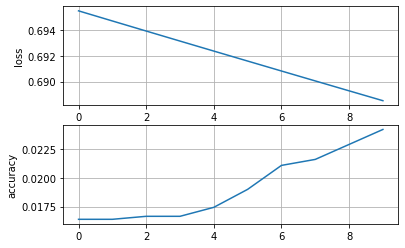

In [17]:
# Here we begin to optimize our model. Our first run of the above cell said: Best parameters:  {'act': 'relu', 'batch_size': 1000, 'opt': 'sgd'}

# Best parameters:  {'act': 'relu', 'batch_size': 1000, 'opt': 'sgd'}
h_nodes = [1000, 500] # two hidden layers with 1000 and 500 nodes, respectively.
myNN = create_NN(hidden_layers=h_nodes, act='relu', opt='sgd', in_dim=X_train.shape[1], out_dim=y_train.shape[1])
myNN.summary()

history1 = myNN.fit(X_train, y_train, epochs=10, batch_size=1000, verbose=2)
fig1, (ax1,ax2) = plt.subplots(2,1)
ax1.set_ylabel("loss")
ax1.plot(history1.epoch, history1.history["loss"])
ax1.grid()

ax2.set_ylabel("accuracy")
ax2.plot(history1.epoch, history1.history["categorical_accuracy"])
ax2.grid()

plt.show()
